# A simple pytorch example

In [22]:
import math
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# The task

The idea is to play around with a neural network to get to know pytorch.

For this purpose we work with a simple dataset that presents for several persons pictures taken from various angles.

The goal is to train a neural network to predict the view of a person from an angle given a different angle. Therefore both the input and the output are images.


# Setup dataset


The used dataset is the [Queen Mary University of London Multiview Face Dataset](http://www.eecs.qmul.ac.uk/~sgg/QMUL_FaceDataset/) which can be downloaded on the page but images are in .ras format.

For convenience I converted them to .png

Here, as we have a small dataset (37 pairs of images), each image is of size 100\*100 but as the dataset is small, it is more interesting to rescale them to a fraction of this size, for instance 16\*16.

Our data is stored in the mainDirectory folder. This main folder contains one subfolder per data sample, which themselves conatain the images. (in our cases two pictures of a person's face from two different view angles) 

We take advantage of the [torch.utils.data.TensorDataset](http://pytorch.org/docs/data.html) utility to create a dataset from torch tensors where the first dimension allows for the indexing of the samples.



Number of training samples :  32
Number of testing samples :  4


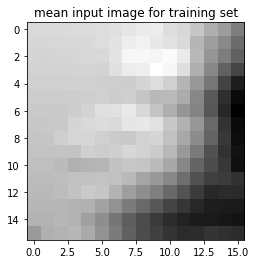

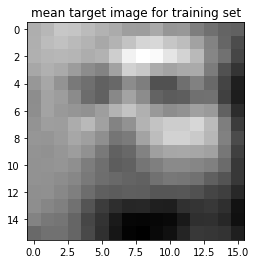

In [26]:
def createDataSetFromDirNames(dirNames, imageSize):
    # This function takes the name of the samples's directories
    # and creates a dataset containing as many samples as there are directories
    # Each sample is composed of an input (one view of a person)
    # and an output (another view of the same person)
    dirNb = len(dirNames)
    dataArray = torch.zeros(dirNb, imageSize, imageSize)
    targetArray = torch.zeros(dirNb, imageSize, imageSize)
    transform = torchvision.transforms.ToTensor()
    for idx, dirName in enumerate(dirNames):
        trainImg = PIL.Image.open( dirName + '/page-0.png')
        targetImg = PIL.Image.open( dirName + '/page-5.png')
        dataArray[idx,] = transform(scipy.misc.imresize(np.array(trainImg), imageSize)).squeeze()
        targetArray[idx,] = transform(scipy.misc.imresize(np.array(targetImg), imageSize)).squeeze()
    # Compute mean image for input and target
    meanInputImage = torch.mean(dataArray, 0)
    meanTargetImage = torch.mean(targetArray, 0)
    return torch.utils.data.TensorDataset(dataArray, targetArray), meanInputImage, meanTargetImage

mainDirectory = '/workdir/hassony/images/Set1_Greyscale/'
directories = os.walk(mainDirectory)
subDirNames = [dir[0] for dir in directories]
subDirNb = len(subDirNames)
trainingNb = math.floor(subDirNb*0.90)

trainingNames = subDirNames[1:trainingNb]
testNames = subDirNames[trainingNb:]

# size to which we want to resize the images
imSize = 16

# create the training and testing datasets
trainDataset, trainMeanInputImage, trainMeanTargetImage = createDataSetFromDirNames(trainingNames, imSize)
testDataset, testMeanInputImage, testMeanTargetImage = createDataSetFromDirNames(testNames, imSize)

print('Number of training samples : ', len(trainDataset))
print('Number of testing samples : ', len(testDataset))

plt.imshow(trainMeanInputImage.numpy().squeeze(), cmap="gray")
plt.title('mean input image for training set')
plt.show()

plt.imshow(trainMeanTargetImage.numpy().squeeze(), cmap="gray")
plt.title('mean target image for training set')
plt.show()

# Some samples from the dataset

Let us display some examples from the dataset

train sample


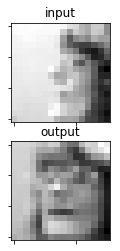

In [27]:
oneTrain = trainDataset.__getitem__(1)[0].numpy()

def drawSample(datasetName, index, meanInpImage, meanTargImage):
    trainImage = datasetName[index][0].numpy()
    targetImage = datasetName[index][1].numpy()
    # Four axes, returned as a 2-d array
    f, axarr = plt.subplots(2)
    axarr[0].imshow(trainImage, cmap = 'gray' )
    axarr[0].set_title('input')
    axarr[1].imshow(targetImage, cmap = 'gray')
    axarr[1].set_title('output')
    # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
    #plt.setp(axarr[0].get_xticklabels(), visible = False)
    plt.setp([a.get_xticklabels() for a in axarr], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr], visible=False)
    plt.show()

print('train sample')
drawSample(trainDataset,0, trainMeanInputImage, trainMeanTargetImage)
#print('test sample')
#drawSample(testDataset, 0, trainMeanInputImage, trainMeanTargetImage)

## Creating the data loader

We then need to configure the dataloaders that will be used for handling the data at training time

In [28]:
trainLoader = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=1)
testLoader = torch.utils.data.DataLoader(testDataset)

## Configuring the neural network
We first create a simple network composed of two full connected layers.
The input is fully connected to 20 hidden nodes which are fully connected to the output 

In [67]:
class SimpleNet(nn.Module):
    def __init__(self, hiddenNodes, imageSize):
        super(SimpleNet, self).__init__()
        self.imageSize = imageSize
        self.fc1   = nn.Linear(pow(imageSize, 2), hiddenNodes )
        self.fc2   = nn.Linear(hiddenNodes, pow(imageSize, 2))

    def forward(self, x):
        x = x.view(-1, pow(self.imageSize, 2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1,self.imageSize,self.imageSize)
        return x

hiddenNodesNumber = 20
simpleNet = SimpleNet(hiddenNodesNumber, imSize)
simpleNet

SimpleNet (
  (fc1): Linear (256 -> 20)
  (fc2): Linear (20 -> 256)
)

# Testing the network with random input

To test the network we do a simple forward pass on a random noise input and display the result.

We would expect a forward pass of a random input through a network with randomly initialized weights to produce noise.

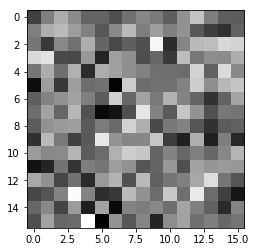

In [68]:
input = Variable(torch.randn(imSize, imSize))
out = simpleNet(input)
plt.imshow(out.data.numpy().squeeze(), cmap = 'gray')
plt.show()

Looks good ! 

Let's train the network now, using a simple mean square error loss on the pixels.

In [69]:
criterion = nn.MSELoss()

def trainNet(dataloader, net, epochNb, learningRate, momentum):
    optimizer = torch.optim.SGD(net.parameters(), learningRate, momentum)
    lossResults = np.zeros(epochNb)
    for epoch in range(epochNb): # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs, labels = data
        
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()        
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i == 31: # print every 2000 mini-batches
                lossResults[epoch] = running_loss
                if epoch % 100 == 0:
                    print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss ))
                running_loss = 0.0
                
    print('Finished Training')
    return lossResults
lossEvolution = trainNet(trainLoader, simpleNet, 2000, 0.001, 0.9)    

[1,    32] loss: 11.779
[101,    32] loss: 0.550
[201,    32] loss: 0.538
[301,    32] loss: 0.532
[401,    32] loss: 0.528
[501,    32] loss: 0.524
[601,    32] loss: 0.520
[701,    32] loss: 0.518
[801,    32] loss: 0.514
[901,    32] loss: 0.512
[1001,    32] loss: 0.509
[1101,    32] loss: 0.506
[1201,    32] loss: 0.504
[1301,    32] loss: 0.501
[1401,    32] loss: 0.498
[1501,    32] loss: 0.496
[1601,    32] loss: 0.493
[1701,    32] loss: 0.490
[1801,    32] loss: 0.487
[1901,    32] loss: 0.485
Finished Training


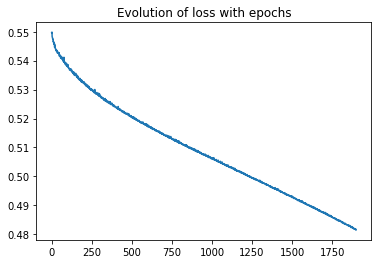

In [75]:
plt.plot(lossEvolution[100:])
plt.title('Evolution of loss with epochs')
plt.show()

Loss is decreasing, which is encouraging.
Let's look at some examples of the prections made on a training and a testing sample

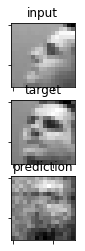

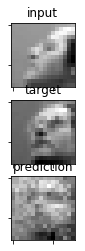

In [71]:
def drawPrediction(net, datasetName, index):
    targetImage = datasetName[index][1].numpy()
    trainImage = datasetName[index][0].numpy()
    trainVar = Variable(torch.Tensor(trainImage))
    predictedVar = net(trainVar)
    trainImage = torch.Tensor(trainImage).numpy()
    predictedIm = predictedVar.data.numpy().squeeze()
    # Four axes, returned as a 2-d array
    f, axarr = plt.subplots(3)
    axarr[0].imshow(trainImage, cmap='gray' )
    axarr[0].set_title('input')
    axarr[1].imshow(targetImage, cmap='gray')
    axarr[1].set_title('target')
    axarr[2].imshow(predictedIm, cmap='gray')
    axarr[2].set_title('prediction')
    # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
    #plt.setp(axarr[0].get_xticklabels(), visible = False)
    plt.setp([a.get_xticklabels() for a in axarr], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr], visible=False)
    plt.show()
    return predictedIm

trainImPred = drawPrediction(simpleNet, trainDataset, 4)
testImPred = drawPrediction(simpleNet, testDataset, 1)

##### This time the produced image doesn't look completely random, we can see something that looks like eyes, we distinguish a chin. Looks like our neural network is learning !
But here we have already iterated on a large number of epochs, but let's see if we can do better with this small dataset ...

Let's increase the number of hidden nodes for instance

In [79]:
simpleNet2 = SimpleNet(100, imSize)
simpleNet2
simpleLoss2 = trainNet(trainLoader, simpleNet2, 2000, 0.001, 0.9)


[1,    32] loss: 11.744
[101,    32] loss: 0.543
[201,    32] loss: 0.529
[301,    32] loss: 0.518
[401,    32] loss: 0.505
[501,    32] loss: 0.493
[601,    32] loss: 0.482
[701,    32] loss: 0.469
[801,    32] loss: 0.456
[901,    32] loss: 0.443
[1001,    32] loss: 0.431
[1101,    32] loss: 0.419
[1201,    32] loss: 0.408
[1301,    32] loss: 0.398
[1401,    32] loss: 0.389
[1501,    32] loss: 0.380
[1601,    32] loss: 0.373
[1701,    32] loss: 0.366
[1801,    32] loss: 0.359
[1901,    32] loss: 0.353
Finished Training


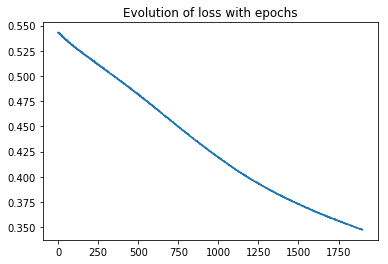

In [80]:
plt.plot(simpleLoss2[100:])
plt.title('Evolution of loss with epochs')
plt.show()

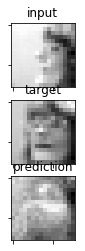

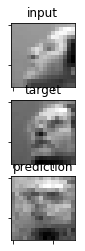

In [76]:
trainImPred = drawPrediction(simpleNet2, trainDataset, 0)
testImPred = drawPrediction(simpleNet2, testDataset, 1)

With this increase of hidden nodes, the loss is lower ! But visually the difference is not much more conclusive.

In [81]:
class DeaperNet(nn.Module):
    def __init__(self, imageSize):
        super(DeaperNet, self).__init__()
        self.imageSize = imageSize
        self.fc1   = nn.Linear(pow(imageSize, 2), 100)
        self.fc2   = nn.Linear(100, 20)
        self.fc3   = nn.Linear(20, 100)
        self.fc4   = nn.Linear(100, pow(imageSize, 2))

    def forward(self, x):
        x = x.view(-1, pow(self.imageSize, 2))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1,self.imageSize,self.imageSize)
        return x

deaperNet = DeaperNet(imSize)
deaperNet
deaperLoss = trainNet(trainLoader, deaperNet, 2000, 0.001, 0.9)


[1,    32] loss: 11.486
[101,    32] loss: 0.537
[201,    32] loss: 0.532
[301,    32] loss: 0.528
[401,    32] loss: 0.524
[501,    32] loss: 0.521
[601,    32] loss: 0.517
[701,    32] loss: 0.513
[801,    32] loss: 0.510
[901,    32] loss: 0.506
[1001,    32] loss: 0.501
[1101,    32] loss: 0.496
[1201,    32] loss: 0.491
[1301,    32] loss: 0.484
[1401,    32] loss: 0.476
[1501,    32] loss: 0.468
[1601,    32] loss: 0.460
[1701,    32] loss: 0.451
[1801,    32] loss: 0.442
[1901,    32] loss: 0.434
Finished Training


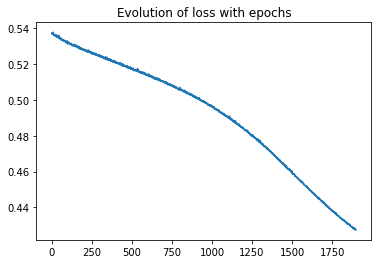

In [83]:
plt.plot(deaperLoss[100:])
plt.title('Evolution of loss with epochs')
plt.show()

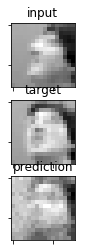

In [85]:
trainImPred = drawPrediction(simpleNet2, trainDataset, 6)